In [2]:
import pandas as pd
import numpy as np

import json
import os

from skimage.io import imread, imshow
import keras

import warnings
warnings.filterwarnings('ignore')

In [3]:
# Open json files
with open('train_list.json') as train_data:
    images = json.load(train_data)

In [4]:
# Create dataframe with image names
df = pd.DataFrame(data=images,columns=['images'])

In [5]:
text_list = os.listdir('labels') # extract text labels

In [6]:
result = []
for angles in text_list:
    f = open(f'labels\{angles}','r')
    result.append(f.readline())

In [7]:
# Convert all strings on the list to float variables
actual_rotation = []
for i in result:
    actual_rotation.append(float(i))

In [8]:
first_image = imread('images/scan_000.png')

Initial image before undergoing filtering


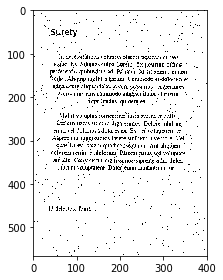

In [10]:
print('Initial image before undergoing filtering')
imshow(first_image);

In [11]:
first_image.shape

(566, 400)

In [12]:
myimages = [] # list to be filled with images

# Loop function to process the images and apply necessary filtering
for img in images:
    image = imread(f'images/{img}')
    inverted_image = np.invert(image) # Black --> White, White --> Black
    for i in range(inverted_image.shape[0]):
        for j in range(inverted_image.shape[1]):
            if inverted_image[i,j] != 0:
                # Starting from the top-left corner of a 3x3 Grid and going clockwise around the center of the grid 
                # This will display data of surrounding blocks from the central point (i.e) point of interest
                mylist = [
                    [i-1,j-1], # top-left
                    [i-1,j], # top-center
                    [i-1,j+1], # top-right
                    [i,j+1], # mid-right
                    [i+1,j+1], # bottom-right
                    [i+1,j], # bottom-center
                    [i+1,j-1], # bottom-left
                    [i,j-1] # mid-left
                ] # Negative number means the grid is off the image, therefore discard only a pair with at least one negative number
                img_list = [[x,y] for x,y in mylist if x >= 0 and y >= 0 and x < inverted_image.shape[0] and y < inverted_image.shape[1]]

                # The img_list must run through the inverted image
                pixel = 0 
                for nums in img_list:
                    pixel += inverted_image[nums[0],nums[1]] 
                
                # Removing the salt & pepper from the image
                if pixel == 0: #checking if the white dot is surrounded by black space hence why I inverted the image
                    inverted_image[i,j] = 0 #i.e if true remove the white dot and turn it black
    
    inverted_image = inverted_image.reshape(inverted_image.shape[0] * inverted_image.shape[1])
    inverted_image = inverted_image.astype('float32') / 255
    myimages.append(inverted_image)

Initial image before undergoing filtering - inverted


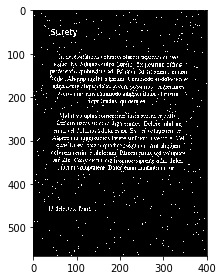

In [13]:
print('Initial image before undergoing filtering - inverted')
imshow(np.invert(first_image));

Image after undergoing processing and filtering


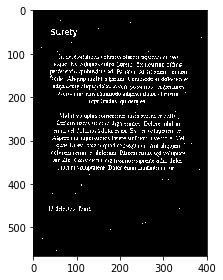

In [14]:
print('Image after undergoing processing and filtering')
imshow(myimages[0].reshape(566, 400));

Less dots on the image which will enable easy text identification and therefore easier identification text angle

In [15]:
myimages = np.array(myimages)

In [16]:
myimages.shape

(500, 226400)

In [17]:
labels = np.array(actual_rotation)

### Model Construction

In [18]:
from keras import models
from keras import layers

In [19]:
def build_model():
    model = models.Sequential()
    model.add(layers.Dense(64, activation='relu',input_shape=(myimages.shape[1],)))
    model.add(layers.Dense(64, activation='relu'))
    model.add(layers.Dense(1))
    model.compile(optimizer='rmsprop',loss='mse',metrics=['mae'])
    return model

In [20]:
k = 4 # number of folds
num_val_samples = len(myimages) // k
num_epochs = 20
all_scores = []
for i in range(k):
    print('processing fold #', i)
    val_images = myimages[i * num_val_samples: (i + 1) * num_val_samples]
    val_labels = labels[i * num_val_samples: (i + 1) * num_val_samples]
    
    partial_train_images = np.concatenate([
        myimages[:i * num_val_samples],
        myimages[(i + 1) * num_val_samples:]
    ],axis=0)
    partial_train_labels = np.concatenate([
        labels[:i * num_val_samples],
        labels[(i + 1) * num_val_samples:]
    ],axis=0)
    
    model = build_model()
    history = model.fit(partial_train_images, partial_train_labels, 
                        validation_data=(val_images, val_labels),
                        epochs=num_epochs, batch_size=1, verbose=0)
    mae_history = history.history['val_mean_absolute_error']
    all_scores.append(mae_history)

processing fold # 0
Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
processing fold # 1
processing fold # 2
processing fold # 3


We can then compute the average of the per-epoch MAE scores for all folds

In [21]:
average_mae_history = [
    np.mean([x[i] for x in all_scores]) for i in range(num_epochs)
]

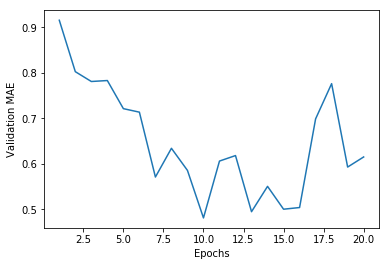

In [22]:
import matplotlib.pyplot as plt
%matplotlib inline

# The requirement is to get MAE less than 1 degree
plt.plot(range(1, len(average_mae_history) + 1), average_mae_history)
plt.xlabel('Epochs')
plt.ylabel('Validation MAE');

10 epochs gives the lowest MAE score